This program takes in a single file in FASTQ format, and output two files:

• A CSV file showing all the detected pairs. It should have the following columns:
    o Barcode 1
    o Number of times barcode 1 was found
    o Barcode 2 (reverse complement of barcode 1)
    o Number of times barcode 2 was found
    
This file is ordered by minimum coverage, that is, the smaller of the two numbers. For
example, if barcode 1 was found 6 times and barcode 2 was found 8 times, the minimum
coverage is 6. In other words, the file should be ordered by reliability of pairing.

• A CSV file containing all the unpaired barcodes and the number of times each one was found. It
should be ordered by number of occurrences.

The program  takes as an input a list corresponding to the barcode base positions, for example:
range(5, 20) or [0, 1, 2, 3, 4, 5].

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from Bio.Seq import (complement, reverse_complement)
#import pyfastx
import pdb
import time


#load the file
file_1 = open('17.Bioinformatics_DNA_sequencing.fq').readlines()

#File is standard fastq format with four lines for each read
#I'll format the file into [-1,4] array and then save it as a DataFrame
file_1_array = np.array(file_1).reshape(-1,4)
fastq_frame_1 = pd.DataFrame(file_1_array, columns=['description', 'sequence', 'newline', 'quality'])


#output_1 will be the first file
output_1 = pd.DataFrame()
#output_2 will be the second one
output_2 = pd.DataFrame(index=None)
#Let's add the other columns required in the output
output_1['sequence'] =np.nan
output_1['Barcode_1'] = np.nan
output_1['Barcode_1_Count'] = np.nan
output_1['Barcode_2'] = np.nan
output_1['Barcode_2_Count'] = np.nan
output_1['minimum_coverage'] = np.nan
output_2['Unpaired_Barcodes'] = np.nan
output_2['Count_Occurence'] = np.nan


#Create the output file templates
output_1['sequence'] = fastq_frame_1['sequence']  #sequence reads column
#remove the whitespace from the sequence
output_1['sequence'] = output_1['sequence'].str.strip()

i = int(input('Enter the first index of the Barcode: '))
j = int(input('Enter the last index of the Barcode: '))+1
barcode_loc = list(range(i,j))

#first six nucleotides are Barcode_1
output_1['Barcode_1'] = output_1['sequence'].str.slice(i,j)
#Reverse complements of Barcode_1 are Barcode_2
output_1['Barcode_2'] = output_1['Barcode_1'].apply(reverse_complement)


# count Barcode_1
barcodes_1 = output_1['Barcode_1']
barcode_counts = {}

for barcode in barcodes_1:  #iterate over the barcodes
    
    if barcode in barcode_counts.keys():  #check if the barcode is seen before
        barcode_counts[barcode]+=1  #if seen, add one to the count
    else:
        barcode_counts[barcode]=1  #if not see, assign 1 as the first count  ##worst case: all of them are unique O(n)
        
output_1['Barcode_1_Count'] = output_1['Barcode_1'].apply(lambda x: barcode_counts[x])


# count Barcode_2
#store each unique barcode_2
barcodes_2 = output_1['Barcode_2'].unique()
#store a counter
barcode_2_counts=dict.fromkeys(barcodes_2,0)

#compare each barcode_1 to the barcodes_2 and count each match

for barcode in barcodes_1:
    if barcode in barcodes_2:
        barcode_2_counts[barcode] +=1
        
    else:
        barcode_2_counts[barcode]=0
        
output_1['Barcode_2_Count'] = output_1['Barcode_2'].apply(lambda x: barcode_2_counts[x])



# Determine the minimum coverage: compare the Barcode_1 and Barcode_2 counts and choose the minimum
output_1['minimum_coverage'] = output_1[['Barcode_1_Count' , 'Barcode_2_Count']].min(axis=1)

#Finalize output_1
output_1 = output_1.sort_values(by='minimum_coverage', ascending=True)

# Now let's group by the Barcodes and aggregate the number of occurances
output_2[['Unpaired_Barcodes', 'Count_Occurence']] =  output_1[output_1['minimum_coverage'] ==0][['Barcode_1', 'Barcode_1_Count']]

# sum the number of occurances
output_2 = output_2.groupby('Unpaired_Barcodes').count().sort_values(by=['Count_Occurence', 'Unpaired_Barcodes'], ascending=False)

Enter the first index of the Barcode: 0
Enter the last index of the Barcode: 5


In [2]:
output_1

,sequence,Barcode_1,Barcode_1_Count,Barcode_2,Barcode_2_Count,minimum_coverage
0,CCACCTTGGACTTGTCACTTGCGGGGC,CCACCT,2,AGGTGG,0,0
584,CTCTGTGTCTTCAAATGGGGCTGGAGG,CTCTGT,1,ACAGAG,0,0
585,CATCATCCCTGGGTGGCCGAGCAGACA,CATCAT,15,ATGATG,0,0
586,GTGCTGATGACTTTCCGCCAAACACTC,GTGCTG,1,CAGCAC,0,0
588,CAGGCTCCTCATGCCAAGGGGCACCTG,CAGGCT,1,AGCCTG,0,0
...,...,...,...,...,...,...
941,AAATTTCAAACTAAAAGGCACCATTGA,AAATTT,21,AAATTT,21,21
847,AAATTTCAAAGAGGAAATCACTATCTA,AAATTT,21,AAATTT,21,21
711,AAATTTGCGCTGACGTGCTCTCCAGGC,AAATTT,21,AAATTT,21,21
743,AAATTTTCCAACTGTTGTGCTGATCAC,AAATTT,21,AAATTT,21,21


In [3]:
output_2.head()

,Count_Occurence
Unpaired_Barcodes,
CATCAT,15
TACGGG,12
AAAAAA,7
CTGTCA,5
TCTTTT,4


# Performance test
## Can we scale this?

   ### Create various versions of the file.

In [4]:
file_list = ['output_1.csv','output_10.csv', 'output_50.csv', 'output_100.csv', 'output_150.csv', 'output_200.csv',\
             'output_250.csv', 'output_300.csv', 'output_350.csv', 'output_400.csv', 'output_450.csv',\
             'output_500.csv', 'output_550.csv', 'output_600.csv', 'output_700.csv', 'output_800.csv',\
             'output_900.csv', 'output_1000.csv', 'output_1_1.csv', 'output_1_2.csv', 'output_1_3.csv',\
             'output_1_4.csv', 'output_1_8.csv', 'output_1_16.csv', 'output_1_50.csv', 'output_1_100.csv',\
             'output_1_200.csv', 'output_1_400.csv', 'output_1_500.csv', 'output_1_700.csv', 'output_200_1.csv',\
             'output_200_2.csv', 'output_200_3.csv', 'output_200_4.csv', 'output_200_8.csv', 'output_200_16.csv',\
             'output_200_50.csv', 'output_200_100.csv', 'output_200_200.csv', 'output_200_400.csv',\
             'output_200_600.csv']

In [5]:
group_1 = ['output_1.csv','output_10.csv', 'output_50.csv', 'output_100.csv', 'output_150.csv', 'output_200.csv',\
             'output_250.csv', 'output_300.csv', 'output_350.csv', 'output_400.csv', 'output_450.csv',\
             'output_500.csv', 'output_550.csv', 'output_600.csv', 'output_700.csv', 'output_800.csv',\
             'output_900.csv', 'output_1000.csv']

group_2 = ['output_1_1.csv', 'output_1_2.csv', 'output_1_3.csv','output_1_4.csv', 'output_1_8.csv',\
                'output_1_16.csv', 'output_1_50.csv', 'output_1_100.csv','output_1_200.csv',\
                'output_1_400.csv', 'output_1_500.csv', 'output_1_700.csv']

group_3 = ['output_200_1.csv','output_200_2.csv', 'output_200_3.csv', 'output_200_4.csv',\
                'output_200_8.csv', 'output_200_16.csv','output_200_50.csv', 'output_200_100.csv',\
                'output_200_200.csv', 'output_200_400.csv','output_200_600.csv']

### Run the program for each data version

In [6]:
times = []
for file in file_list:    
    output_2 = pd.DataFrame()    
    output_2 = pd.DataFrame()    
    output_1 = pd.read_csv(file).drop('Unnamed: 0', axis=1)
    x =time.time()
    i,j = 0,5
    output_1['Barcode_1'] = output_1['sequence'].str.slice(i,j)
    output_1['Barcode_2'] = output_1['Barcode_1'].apply(reverse_complement)
    barcodes_1 = output_1['Barcode_1']
    barcode_counts = {}
    for barcode in barcodes_1:  #iterate over the barcodes
        if barcode in barcode_counts.keys():  #check if the barcode is seen before
            barcode_counts[barcode]+=1  #if seen, add one to the count
        else:
            barcode_counts[barcode]=1  #if not see, assign 1 as the first count  ##worst case: all of them are unique O(n)
    output_1['Barcode_1_Count'] = output_1['Barcode_1'].apply(lambda x: barcode_counts[x])
    barcodes_2 = output_1['Barcode_2'].unique()
    barcode_2_counts=dict.fromkeys(barcodes_2,0)
    for barcode in barcodes_1:
        if barcode in barcodes_2:
            barcode_2_counts[barcode] +=1
        else:
            barcode_2_counts[barcode]=0
    output_1['Barcode_2_Count'] = output_1['Barcode_2'].apply(lambda x: barcode_2_counts[x])
    output_1['minimum_coverage'] = output_1[['Barcode_1_Count' , 'Barcode_2_Count']].min(axis=1)
    output_1 = output_1.sort_values(by='minimum_coverage', ascending=True)
    output_2[['Unpaired_Barcodes', 'Count_Occurence']] =  output_1[output_1['minimum_coverage'] ==0][['Barcode_1', 'Barcode_1_Count']]
    output_2 = output_2.groupby('Unpaired_Barcodes').count().sort_values(by=['Count_Occurence', 'Unpaired_Barcodes'], ascending=False)
    y = time.time()
    z = (y-x)
    times.append(((len(output_1), len(output_1['sequence'][0]),z)))
    print({'rows':len(output_1), 'length':len(output_1['sequence'][0]),'runtime':z})


scores = pd.DataFrame(times, columns=['# of rows', 'length of sequence','Time(s)'])



{'rows': 1000, 'length': 27, 'runtime': 0.05300259590148926}
{'rows': 1000, 'length': 270, 'runtime': 0.04500532150268555}
{'rows': 1000, 'length': 1350, 'runtime': 0.03703451156616211}
{'rows': 1000, 'length': 2700, 'runtime': 0.05467677116394043}
{'rows': 1000, 'length': 4050, 'runtime': 0.03126239776611328}
{'rows': 1000, 'length': 5400, 'runtime': 0.049184560775756836}
{'rows': 1000, 'length': 6750, 'runtime': 0.031282901763916016}
{'rows': 1000, 'length': 8100, 'runtime': 0.048047542572021484}
{'rows': 1000, 'length': 9450, 'runtime': 0.03725242614746094}
{'rows': 1000, 'length': 10800, 'runtime': 0.04687952995300293}
{'rows': 1000, 'length': 12150, 'runtime': 0.031252384185791016}
{'rows': 1000, 'length': 13500, 'runtime': 0.050432682037353516}
{'rows': 1000, 'length': 14850, 'runtime': 0.05100297927856445}
{'rows': 1000, 'length': 16200, 'runtime': 0.0999917984008789}
{'rows': 1000, 'length': 18900, 'runtime': 0.06901025772094727}
{'rows': 1000, 'length': 21600, 'runtime': 0.067

## Report

In [7]:
import matplotlib.pyplot as plt

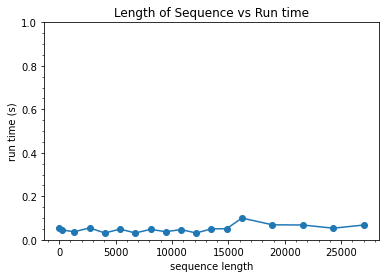

In [8]:
x = []
y = []
for i in times[:len(group_1)]:
    x.append(i[1])
    y.append(i[2])
    
plt.scatter(x,y)
plt.plot(x,y)
plt.ylim(0,1)
plt.xlabel('sequence length')
plt.ylabel('run time (s)')
plt.title('Length of Sequence vs Run time')
plt.minorticks_on()
plt.show()

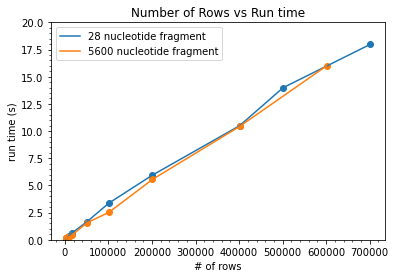

In [11]:
# Fragment length vs Number of Rows

x = []
y = []
for i in times[len(group_1):len(group_1)+len(group_2)]:
    x.append(i[0])
    y.append(i[2])    
plt.scatter(x,y)
plt.plot(x,y)
#plt.xlim(0,6000)
plt.ylim(0,20)
plt.xlabel('# of rows')
plt.ylabel('run time (s)')
plt.title('Number of Rows vs Run time')
plt.minorticks_on()


x = []
y = []
for i in times[len(group_1)+len(group_2):]:
    x.append(i[0])
    y.append(i[2])    
plt.scatter(x,y)
plt.plot(x,y)
plt.minorticks_on()
plt.legend(['28 nucleotide fragment','5600 nucleotide fragment'])
plt.show()